# Modified Kernel Function

## Motivation

While using Kde, we often wonder which kernel function to use as the choice of kernel function impacts the effectiveness of this method by a lot.

A good choice of kernel function may insure the convergence of the estimate towards the true pdf function, it can also reduce number of samples we require to get to a good estimate.

I think an example would be a good starting point, imagine using f(t) = u(t + 5) - u(t + 4.5) + u(t - 4.5) - u(t - 5), as a kernel function. This is very easy to see in this case why this would not converge but in several other cases it's not and thus we need a better approach to pick Kernel functions from the gazillions of the options we have.

## Proposed Approach

Here is one of my proposed solution to the problem of the choice of kde.

This argument hinges on the fact that gaussian kernerl is generally a good kernel with large number of samples. So it may give us the picture of the true density function.

Now the question arises why not stick to the Gaussian kde if it converges for the most cases? The answer to that is simple: Gaussian does converge but the number of samples we need can be really high, with a good choice of the bandwith it can be reduced to an extent but we can go further than this.

We device a kernel such that it preserves this picture of the true density function formed using gaussian estimation and improves upon it with this new data.
For this we are going to use KL divergence and minimise it between the gaussian estimate and our modified kernel estimate.


\* In my observation during this IP, usually whenever I encounter an exotic pdf it can be estimated using the same pdf as a kernel to itself. This point is not a part of my main argument but it helps validate what I am going to do from this point on.

In [92]:
import numpy as np
from scipy.stats import lognorm
from scipy.fft import fft, ifft, fftfreq
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:
x_axis: np.ndarray = np.linspace(-5, 15, 1000)
S_m: np.ndarray = lognorm(s = 1, scale = 1, loc = 0).rvs(size = 600)
S_n: np.ndarray = lognorm(s = 1, scale = 1, loc = 0).rvs(size = 450)
S_e: np.ndarray = lognorm(s = 1, scale = 1, loc = 0).rvs(size = 900)

In [187]:
def gaussian_kernel(_samples):
    h = 1.06 * np.std(_samples) * len(_samples) ** (-1/5)
    def inner(x: float):
        return np.exp(-0.5 * (x / h) ** 2) / (np.sqrt(2 * np.pi) * h)
    return inner


def calculate_kde(_samples: np.ndarray, _kernel: callable = None) -> callable:
    if _kernel is None:
        _kernel = gaussian_kernel(_samples)
    def inner(x: float) -> float:
        val = 0
        for sample in _samples:
            val += _kernel(x - sample)
        val = val / len(_samples)
        return val
    return inner

f = calculate_kde(S_m)

## Minimizing the KL divergence

KL divergence between any two functions P and Q can be expressed as:
$$
    KL(P||Q) = \int_{-\infty}^{\infty} P(t) ln(\frac{P(t)}{Q(t)}) dt
$$

This minimization can be done in several ways with different constraints.

But for this presentation we are using Euler Lagrange Equation:
$$
    \frac{\partial F}{\partial y} - \frac{d}{dx} \frac{\partial F}{\partial y^{'}} = 0
$$
This equation is used to solve for y(x), such that for some path C, it minimises the expression:
$$
    \int_{C} F(y, y^{'}, x) dx
$$

### Choice of constrains
I have figured out few constrains that give us few benefits but they are not feasible form a practical standpoint. So in this case I am going to use Euler Lagrange equation
directly on the KL divergence without any constrains or modifications to P or Q.
Solutions exist with modifications as well one example will be:
$$
    P(f(K), S) = \sum_{i = 0} ^ n f(x - S[i])
    \\ \text{where, } f(K) = K(x)K^{'}(x)
$$

But continuing with our choices will get us:
$$
    \frac{\partial (P(x) ln(\frac{P(x)}{Q(x)}))}{\partial K} - \frac{d}{dx} \frac{\partial (P(x) ln(\frac{P(x)}{Q(x)}))}{\partial K^{'}} = 0.
    \\ \frac{\partial (P(x) ln(\frac{P(x)}{Q(x)}))}{\partial K} = 0
    \\ \therefore cP = Q
$$

where c is a constast.
$\\$ This is a trivial solution but this agrees with the observation I mentioned.

## Updated Kernel Formulation

Given ($n < m$) $\wedge$ (n,m $\in$ $\mathbb{Z}_{>0}$),
and $S_k$ is the set of samples with order k.
$\\$ K(x): updated Kernel function.
$\\$ $p(K(x), S_n)$ is our intermediary function
$$
    p(K(x), S_n) = \frac{1}{nh}\sum_{i = 1}^n K(\frac{x - S[i]}{h})
$$
$\\$ while $q(x, S_m)$ is our Gaussian kde.
$$
    q(x, S_m) = \frac{1}{nh}\sum_{i = 0}^m \frac{1}{\sqrt{2\pi}} e^{\frac{- (\frac{x - S[i]}{h})^{2}}{2}}
$$


Now, as p = q.
we can express it as: 
$$
    \frac{1}{nh}\sum_{i = 1}^n K(\frac{x - S[i]}{h}) = q(x, S_m)
$$
By applying Laplace transform on both sides we get:
$$
    (\frac{1}{n} \sum_{i = 1}^n e^{- x_i s}) K(hs) = Q(s)
$$
Further,
$$
    K(hs) = \frac{Q(s)}{\frac{1}{n} \sum_{i = 1}^n e^{- x_i s}}
$$
By applying, inverserse Laplace transform on both sides we get:
$$
    \frac{1}{h} K(\frac{x}{h}) = \mathcal{L}^{-1}(\frac{Q(s)}{\frac{1}{n} \sum_{i = 1}^n e^{- x_i s}})
$$
Finally,
$$
    K(x) = h\mathcal{L}^{-1}(\frac{Q(s)}{\frac{1}{n} \sum_{i = 1}^n e^{- x_i s}})(hx)
$$

In [188]:
def modified_kernel(_samples: np.ndarray, _kde: callable, _axis: np.ndarray) -> callable:
    h = 1.06 * np.std(_samples) * len(_samples) ** (-1/5)
    def bias(s: np.complex_) -> np.complex_:
        dump: np.complex_ = np.complex_(0 + 0j)
        for sample in _samples:
            exp_value = np.exp(np.clip(-s * sample, -1400, 1400))  # Clip to avoid overflow
            dump += exp_value
        return dump if dump != 0 else np.complex_(1 + 0j)  # Avoid division by zero

    dif = abs(_axis[1] - _axis[0])
    Q_s = fft(_kde(_axis))
    xf = fftfreq(len(_axis), dif)
    for indx, w in enumerate(xf):
        s = w * 1j
        bias_value = bias(s)
        if np.abs(bias_value) > 1e-10:  # Avoid division by very small numbers
            Q_s[indx] = h * len(_samples) * Q_s[indx] / bias_value
        else:
            Q_s[indx] = 0  # Handle invalid division

    q_t = ifft(Q_s).real

    def inner(x: float) -> float:
        x = x * h
        if x < _axis[0] or x > _axis[-1]:
            return 0
        indx: int = int(abs(x - _axis[0]) / dif)
        return q_t[indx]
    
    return inner



kernel = modified_kernel(S_n, f, x_axis)


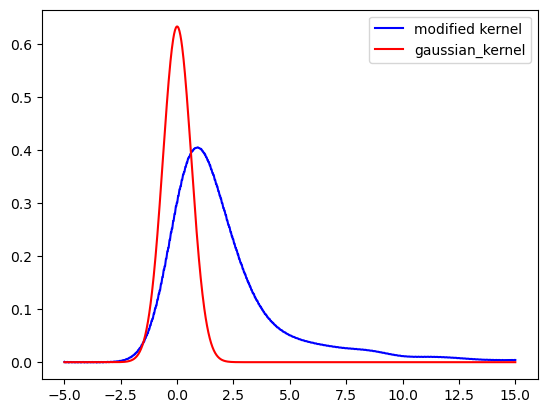

In [192]:
gus = gaussian_kernel(S_n)
h = 1.06 * np.std(S_n) * len(S_n) ** (-1/5)
k_on_samples = [kernel(x)/ h for x in x_axis]
plt.plot(x_axis, k_on_samples, color = 'blue', label = 'modified kernel')
plt.plot(x_axis, gus(x_axis), color = 'red', label = 'gaussian_kernel')
plt.legend()
plt.show()

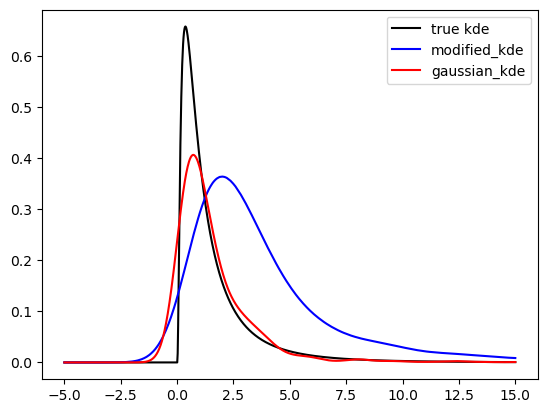

In [193]:
plt.plot(x_axis, lognorm(s=1, scale=1, loc=0).pdf(x_axis), label='true kde', color='black')
modified_kde = calculate_kde(S_e, kernel)
h = 1.06 * np.std(S_e) * len(S_e) ** (-1/5)
modified_kde_array = [modified_kde(x)/(h) for x in x_axis]
plt.plot(x_axis, modified_kde_array, color = 'blue', label = 'modified_kde')
gaussian_kde = calculate_kde(S_e)
plt.plot(x_axis, gaussian_kde(x_axis), color = 'red', label = 'gaussian_kde')
plt.legend()
plt.show()

## Conclusion

\* This code has some scaling errors and these are induced while using fourier transform, I have tried to mitigate some of them using scalar multiplication. But the problem persists. My previous code was better in this regard but due to unforseen circumstances my laptop's screen stopped working. This is a example code for grading but I will present the corrected code by the end of the week.


We can see modified Kernel resembles something in between the true density function and the gaussian kernel. This approch that I immplemented is has a smoother curve than the gaussian kde but the kernel function doesn't vanish as fast it creates errors and these errors adds up, this issue can be resolved by multiplying both kernels together and using it as the new kernel with normalization.

As it is end of my IP, I would like to thank you for provinding me with this opportunity.